In [1]:
import sys
import json
import warnings

import numpy as np
import scanpy as sc
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from matplotlib.colors import LinearSegmentedColormap
from utils import UnimapResult, set_plot_theme, generate_positions

set_plot_theme()
warnings.filterwarnings('ignore')

In [2]:
mg_query = sc.read_h5ad( '../../data/mg/mg_query.h5ad')
mg_hvgs = pkl.load(open( '../../data/mg/hvg_1649_mg.pkl', "rb"))
result = UnimapResult('mg', 'unimap/2023', root_dir='../../results')

mg_query.obs = pd.concat([mg_query.obs, result.t_result.loc[:, ['pred_celltype', 'pred_cell_prob']]], axis=1)
mg_query.obsm['X_emb'] = result.t_z_result.values
mg_query.var_names_make_unique()
mg_query = mg_query[mg_query.obs['celltype'] != 'nan', :]
sc.pp.filter_cells(mg_query, min_genes=200)
sc.pp.filter_genes(mg_query, min_cells=3)
sc.pp.normalize_total(mg_query, target_sum=1e6)  # cpm
sc.pp.log1p(mg_query)
mg_query = mg_query[:, mg_query.var.index.isin(mg_hvgs)]
mg_query.raw = mg_query

mg_query.obsm['X_pca'] = result.t_z_result.reindex(mg_query.obs.index).values
mg_query.obsm['X_umap'] = result.t_umap_result.reindex(mg_query.obs_names).values

color_dict = json.load(open('../../color_dict.json'))
ct_c = color_dict["mg_ct_query"]
pd_ct_c = color_dict["mg_ct_ref"]

  Checking mg unimap/2023 result   
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ File                 ┃ Exist    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ st_result.csv        │ ✔️        │
│ history.csv          │ ✔️        │
│ st_z_result.csv      │ ✔️        │
│ st_umap_result.csv   │ ✔️        │
│ t_prob_result.csv    │ ✔️        │
└──────────────────────┴──────────┘

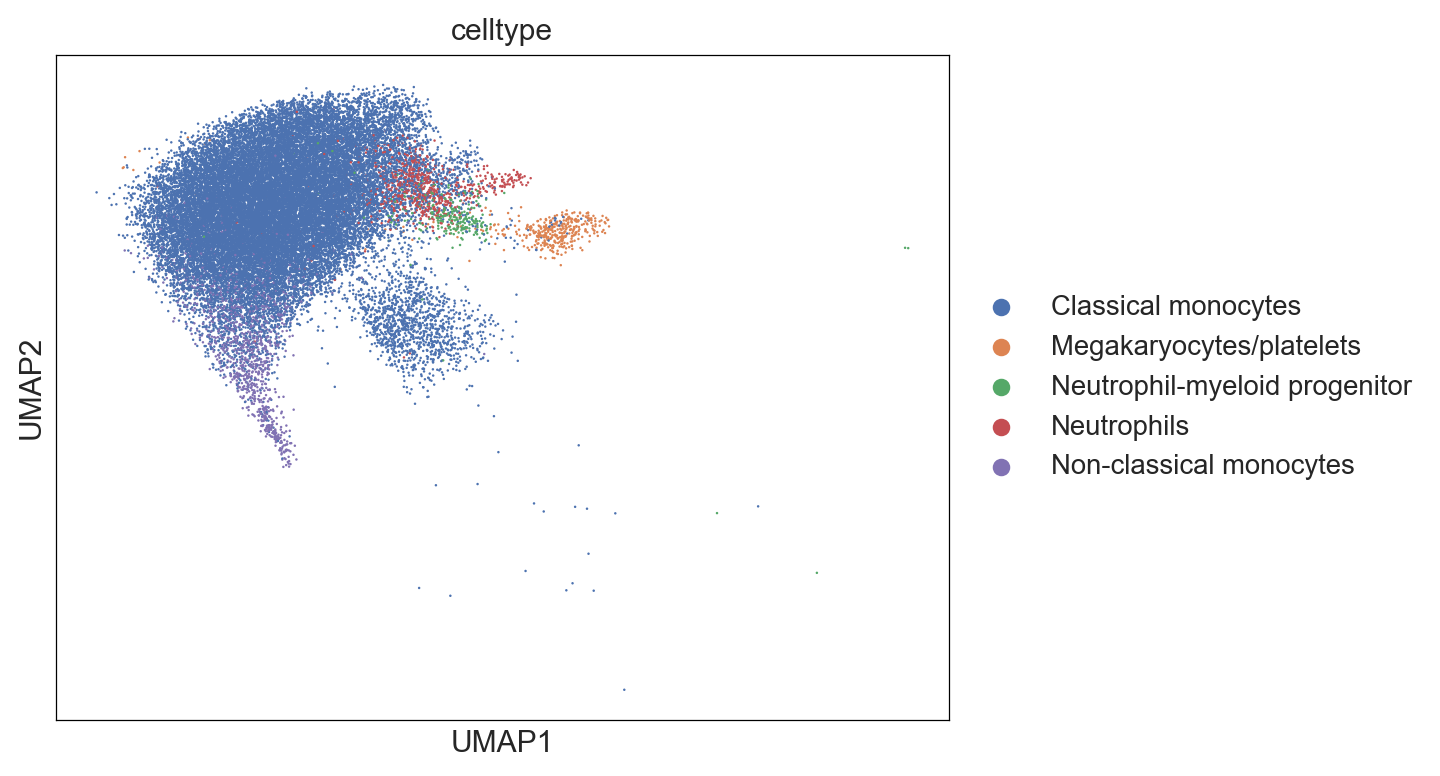

In [3]:
myeloid_t = mg_query[(mg_query.obs['pred_celltype'].isin(["Monocyte (CD14)", "Monocyte (CD16)"])) & (mg_query.obs['celltype'].isin(["Classical monocytes", "Non-classical monocytes", "Neutrophils", "Megakaryocytes/platelets", "Neutrophil-myeloid progenitor"]))].copy()
sc.pl.umap(myeloid_t, color='celltype')

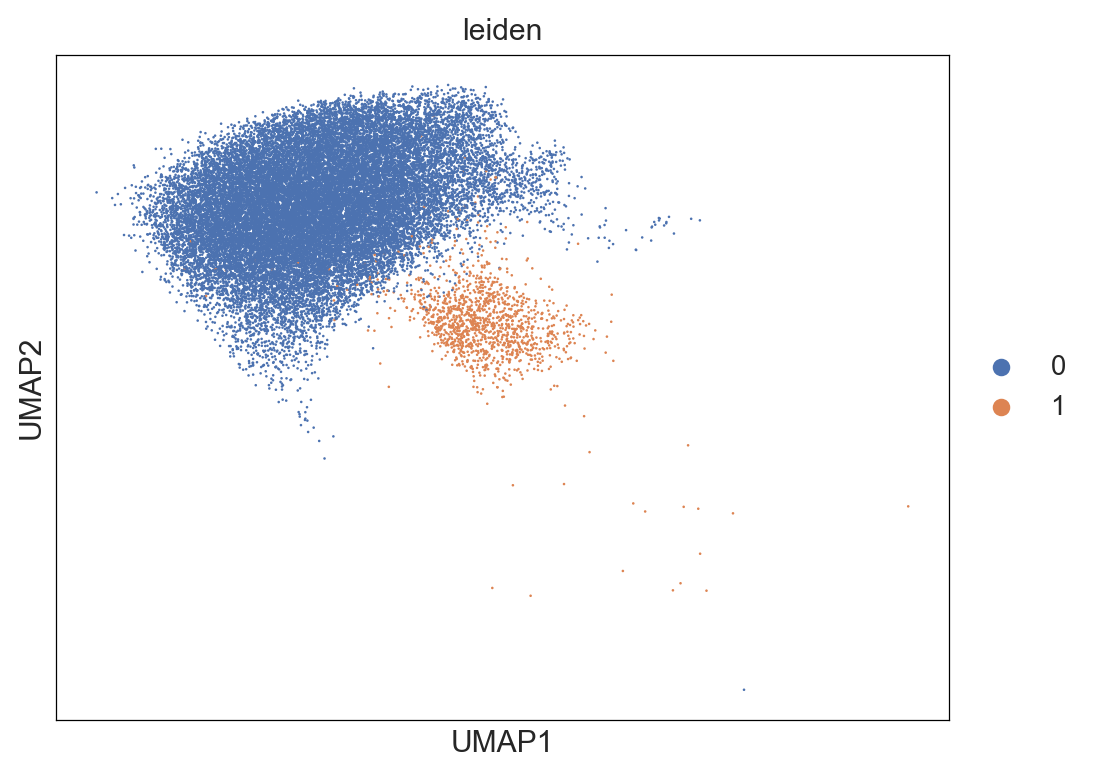

In [4]:
myeloid_t_no_anno = myeloid_t[(myeloid_t.obs['pred_celltype'].isin(["Monocyte (CD14)", "Monocyte (CD16)"])) & (myeloid_t.obs['celltype'].isin(["Classical monocytes"]))].copy()
sc.pp.neighbors(myeloid_t_no_anno, n_neighbors=15, n_pcs=128, use_rep='X_pca')
sc.tl.leiden(myeloid_t_no_anno, resolution=0.1)  # 1.1
sc.pl.umap(myeloid_t_no_anno, color='leiden')


In [5]:
cluster_dict = {'0': 'Cluster1',
                '1': 'Cluster2',
                }
myeloid_t_no_anno.obs['leiden'] = myeloid_t_no_anno.obs['leiden'].replace(cluster_dict)
myeloid_t.obs['mye_label'] = list(myeloid_t.obs['celltype'])
myeloid_t.obs.loc[myeloid_t_no_anno.obs.index, 'mye_label'] = myeloid_t_no_anno.obs['leiden']

In [6]:
sc.tl.rank_genes_groups(myeloid_t, "mye_label", method="t-test")
# sc.pl.rank_genes_groups(myeloid_t, n_genes=25, sharey=False)
myeloid_marker_list = list(set(pd.DataFrame(myeloid_t.uns["rank_genes_groups"]["names"]).head(5).values.flatten()))

myeloid_marker_dict = {
    col: list(pd.DataFrame(myeloid_t.uns["rank_genes_groups"]["names"]).head(5)[col]) for col in pd.DataFrame(myeloid_t.uns["rank_genes_groups"]["names"]).columns
}

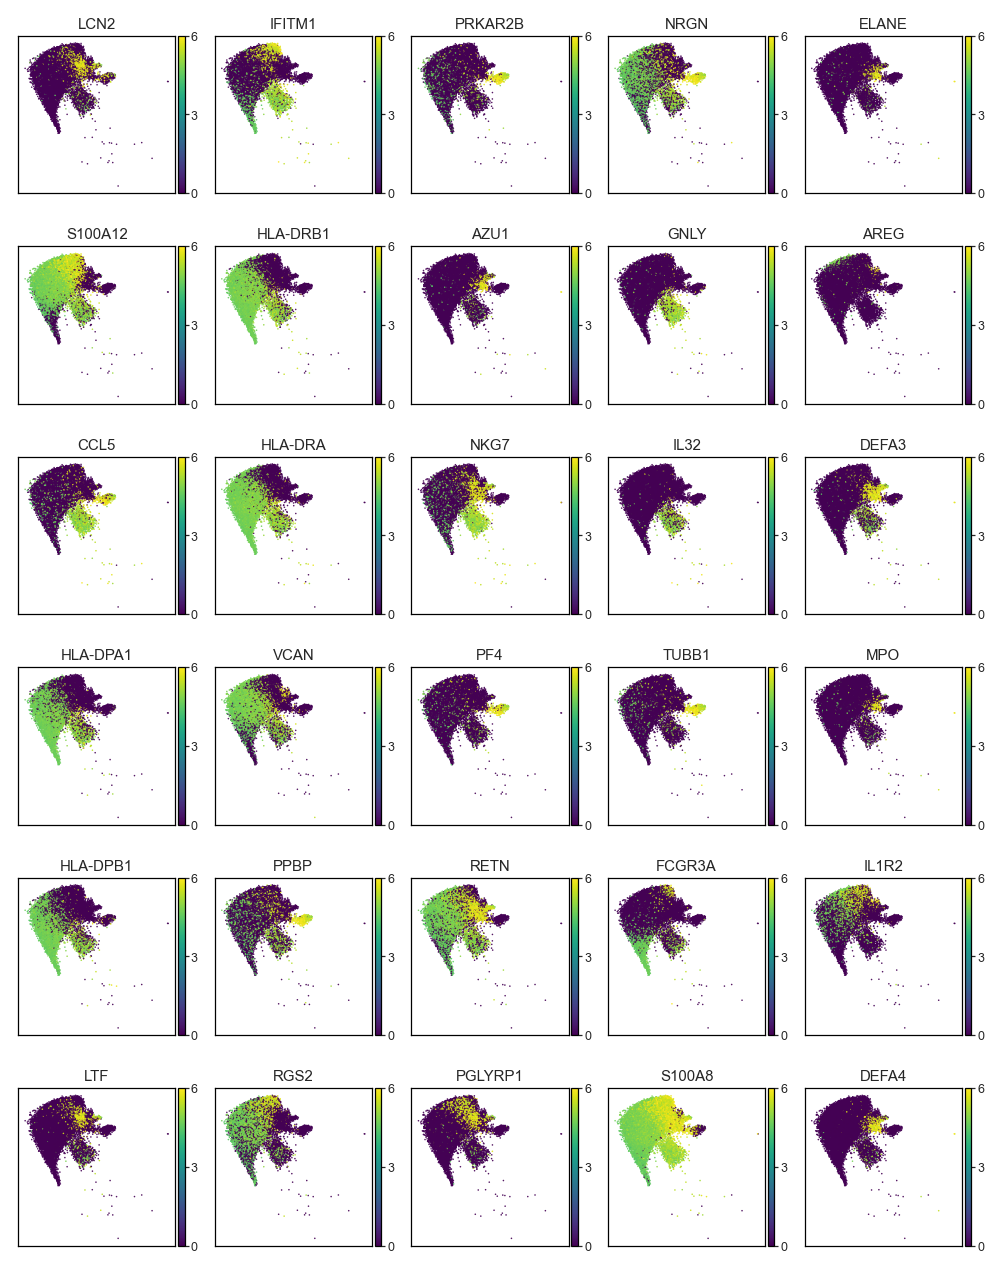

In [7]:
result.umap_genex(adata=myeloid_t, genelist=myeloid_marker_list).savefig('../sup_figs/sup11.png', dpi=720)

In [53]:
# sc.pl.umap(myeloid_t, color=set(myeloid_marker_list))  # 'LCN2' 和 PGLYRP1


In [54]:
# myeloid_marker_dict = {
#  'Cluster1': ['IL1R2', 'AREG', 'RGS2', 'CD14'],
#  'Non-classical monocytes': ['RHOB', 'MAFB', 'IFI30', 'FCGR3A'],
#  'Cluster2': ['IFITM1','GNLY',  'IL32'],

#  'Megakaryocytes/platelets': ['PPBP',  'TUBB1', 'PRKAR2B', 'PF4'],
#  'Neutrophil-myeloid progenitor': [ 'DEFA4', 'AZU1', 'ELANE', 'MPO'],
#  'Neutrophils': [ 'LTF', 'LCN2', 'PGLYRP1'],
#  }

# ax = sc.pl.dotplot(myeloid_t, myeloid_marker_dict, groupby='mye_label', color_map='viridis', linewidth=0.7, show=False,figsize=(10,3), categories_order=myeloid_marker_dict.keys())

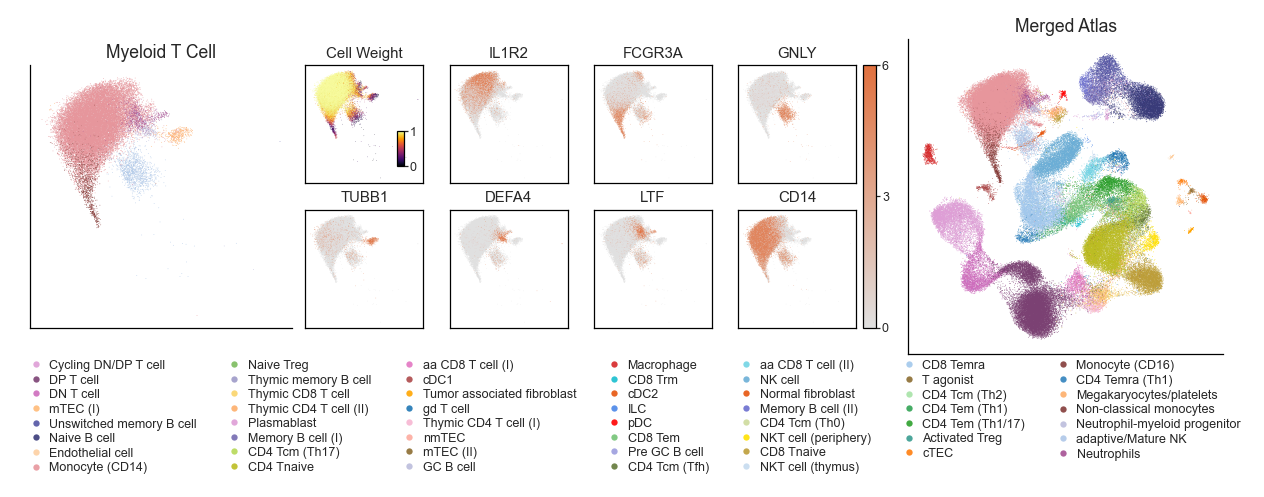

In [8]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

w, h = 0.09, 0.09 / (250/185)
position1 = [[0.02, 0.6000, 0.20, 0.20 / (250/185)]]
position2 = [[0.23, 0.6814, w, h], [0.34, 0.6814, w, h], [0.45, 0.6814, w, h], [0.56, 0.6814, w, h],
             [0.23, 0.6000, w, h], [0.34, 0.6000, w, h], [0.45, 0.6000, w, h], [0.56, 0.6000, w, h]]
position4 = [[0.655, 0.6000, 0.01, 0.20 / (250/185)]]
position3 = [[0.69, 0.5852, 0.24, 0.24 / (250/185)]]

pd_ct_c.update({
    'Cluster1': '#e6969c',
    'Cluster2': '#aec7e8',
    'adaptive/Mature NK': '#aec7e8',

    'platelets': '#e6550d',
    'Non-classical monocytes': '#843c39',
    'Neutrophils': '#a55194',
    'Megakaryocytes/platelets': '#fdae6b',
    'Neutrophil-myeloid progenitor': '#bcbddc',
})



p1 = sns.scatterplot(x=myeloid_t.obsm['X_umap'][:, 0], y=myeloid_t.obsm['X_umap'][:, 1], alpha=0.9, s=0.1, hue=myeloid_t.obs.mye_label, edgecolor='none', palette=pd_ct_c, ax=fig.add_axes(position1[0]), rasterized=True)
result.remove_ticks(p1, remove_legend=True)
p1.set_title('Myeloid T Cell', fontsize=7, pad=3)
p1.spines['top'].set_visible(False)
p1.spines['right'].set_visible(False)

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#E0E0E0', '#E1713F'] )
genes = ['Cell Weight', 'IL1R2', 'FCGR3A', 'GNLY', 'TUBB1', 'DEFA4', 'LTF', 'CD14',]  #  'DEFA3', 


for idx,gene in enumerate(genes):
    if gene == 'Cell Weight':
        p2 = sns.scatterplot(x=myeloid_t.obsm['X_umap'][:, 0], y=myeloid_t.obsm['X_umap'][:, 1], alpha=0.9, s=0.05, hue=myeloid_t.obs.pred_cell_prob, edgecolor='none', palette='inferno', ax=fig.add_axes(position2[idx]), rasterized=True)
        result.remove_ticks(p2, remove_legend=True)
        p2.set_title(gene, fontsize=6, pad=3)
    else:
        p2 = sns.scatterplot(x=myeloid_t.obsm['X_umap'][:, 0], y=myeloid_t.obsm['X_umap'][:, 1], alpha=0.9, s=0.05, hue=myeloid_t.X[:, myeloid_t.var_names.get_loc(gene)].toarray().flatten(), edgecolor='none', palette=custom_cmap, ax=fig.add_axes(position2[idx]), rasterized=True)
        p2.set_title(gene, fontsize=6, pad=3)
        result.remove_ticks(p2, remove_legend=True)


cluster_name_dict = {'Cluster1': 'Monocyte (CD14)', 'Cluster2': 'adaptive/Mature NK'}
                
myeloid_t.obs['mye_label'] = myeloid_t.obs['mye_label'].replace(cluster_name_dict)


result.t_result['new_ct'] = result.t_result.pred_celltype
result.t_result.loc[myeloid_t.obs.index, 'new_ct'] = myeloid_t.obs['mye_label']
umaps = result.st_umap_result
labels = list(result.s_result['celltype']) + list(result.t_result['new_ct'])
p4 = sns.scatterplot(x=umaps['umap1'], y=umaps['umap2'], alpha=0.9, s=0.1, hue=labels, edgecolor='none', palette=pd_ct_c, ax=fig.add_axes(position3[0]), rasterized=True)
result.remove_ticks(p4, remove_legend=False)
p4.legend(loc='center left', bbox_to_anchor=(-2.85, -0.20), frameon=False, markerscale=8, fontsize=5, labelspacing=0.2, ncol=7, columnspacing=2, handletextpad=0.1)
p4.set_title('Merged Atlas', fontsize=7, pad=3)
p4.spines['top'].set_visible(False)
p4.spines['right'].set_visible(False)

cbar_ax1 = fig.add_axes(position4[0])
norm1 = plt.Normalize(vmin=0, vmax=6)
sm1 = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm1)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_ticks([0, 3, 6])
cbar1.set_ticklabels(['0', '3', '6'])
cbar1.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)


cbar_ax1 = fig.add_axes([0.30, 0.691, 0.005, 0.02])  # [left, bottom, width, height]
norm1 = plt.Normalize(vmin=0, vmax=1)
sm1 = plt.cm.ScalarMappable(cmap='inferno', norm=norm1)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['0', '1'])
cbar1.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

In [9]:
# fig.savefig('../figs/fig5.pdf', dpi=720)